In [23]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import numpy as np
import itertools
from itertools import permutations, combinations
import time
from pylab import *

torch.manual_seed(1)                      # reproducible
torch.set_printoptions(threshold=np.inf)  # print all

def findByRow(mat, row):
    return np.where((mat == row).all(1))[0]


# ----- Step 1: Set Hyper Parameters ----- #

NAME = 'DNN-MNIST'
OUTPUT_CLASS = 10

RELEASE_LISTS = [
    [2,3],
    [3,2]
]
RELEASE_FACTOR = 0.1

LR = 0.01
BATCH_SIZE = 400

TURNS = 150

K = 3
T = 20

K_release = K-1
T_max = T-1


# ----- Step 2: Load MNIST Dataset and Create Loader ----- #

train_data = dsets.MNIST(root='../Datasets', train=True, transform=transforms.ToTensor(), download=True)
test_data = dsets.MNIST(root='../Datasets', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

train_X = train_data.train_data.type(torch.FloatTensor)/255.
train_Y = train_data.train_labels.numpy()
test_X = test_data.test_data.type(torch.FloatTensor)/255.
test_Y = test_data.test_labels.numpy()

train_Y1 = train_data.train_labels.type(torch.LongTensor)

y_train_onehot = torch.nn.functional.one_hot(train_Y1)


# ----- Step 3: Create Model Class ----- #

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = torch.nn.Linear(784, 32)
        self.l2 = torch.nn.Linear(32, 10)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.l1(x))
        return self.l2(x)


# ----- Step 4: Instantiate ----- #

model = Net()
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

MS_loss_fn = torch.nn.MSELoss()


# ----- Step 5: Model Training ----- #

turns_record = []
loss_record = []
MS_loss_record = []
train_acc_record = []
F1_record = []
MCC_record = []
Score_record = []

total_loss_time = 0
total_MS_loss_time = 0
total_acc_time = 0
total_F1_time = 0
total_MCC_time = 0
total_Score_time = 0          

turns_index = 0
for turns in range(1, 2):
    for batch_idx, data in enumerate(train_loader, 0):
        turns_index += 1
        
        inputs, target = data
        optimizer.zero_grad()  # clear gradients for this training step
        outputs = model(inputs)
        loss = loss_fn(outputs, target)
        loss.backward()        # backward and compute gradients
        optimizer.step()       # apply gradients
    
        # Shared Part - train_output
        SP_trainout_time_part_start = time.time()
        train_output = model(train_X)
        SP_trainout_time_part_stop = time.time()

        # Shared Part - softmax
        SP_softmax_time_part_start = time.time()
        train_output_result = F.softmax(train_output, dim=1)  # softmax in last dim
        SP_softmax_time_part_stop = time.time()

        # Shared Part - pred_train_y
        SP_predy_time_part_start = time.time()
        pred_train_y = torch.max(train_output, 1)[1].data.numpy()
        SP_predy_time_part_stop = time.time()

        # Acc
        acc_time_part_start = time.time()
        train_accuracy = float((pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
        acc_time_part_stop = time.time()

        # MS Loss
        MS_loss_time_part_start = time.time()
        MS_train_loss = MS_loss_fn(train_output_result, y_train_onehot)
        MS_loss_time_part_stop = time.time()

        # CE Loss
        loss_time_part_start = time.time()
        train_loss = loss_fn(train_output, train_Y1)
        loss_time_part_stop = time.time()

        # F1
        F1_time_part_start = time.time()
        F1 = f1_score(train_Y, pred_train_y, average='macro')
        F1_time_part_stop = time.time()

        # MCC
        MCC_time_part_start = time.time()
        MCC = matthews_corrcoef(train_Y, pred_train_y)
        MCC_time_part_stop = time.time()

        # Score
        Score_time_part_start = time.time()
        output_results = train_output_result.detach().numpy()
        prediction_pattern = np.argsort(-output_results)[:, :K]  # sorted_states_index
        confidence_pattern = T_max - np.floor((-np.sort(-output_results)[:, :K]) * T)  # sorted_states_t
        confidence_pattern[confidence_pattern == -1] = 0

        total_score = 0
        pattern_num = len(confidence_pattern)
        release_factors = np.ones((pattern_num, K))

        for i in range(pattern_num):
            current_prediction_pattern = list(prediction_pattern[i])
            if train_Y[i] in current_prediction_pattern:
                correct_index = current_prediction_pattern.index(train_Y[i])
                confidence_pattern[i][correct_index] = T_max - confidence_pattern[i][correct_index]
                release_factors[i][correct_index] = K_release

                for release_list in RELEASE_LISTS:
                    if current_prediction_pattern[correct_index] == release_list[0]:
                        for j in range(K):
                            if j != correct_index and current_prediction_pattern[j] in release_list[1:]:
                                release_factors[i][j] = RELEASE_FACTOR

        release_factors /= release_factors.sum(axis=1).reshape(-1,1)
        confidence_pattern[confidence_pattern == 0] = 1e-7
        confidence_pattern = -np.log(confidence_pattern / T_max)
        total_score = (np.multiply(release_factors, confidence_pattern).sum()) / pattern_num
        Score_time_part_stop = time.time()

        # (Test Acc)
        test_output = model(test_X)
        pred_test_y = torch.max(test_output, 1)[1].data.numpy()
        test_accuracy = float((pred_test_y == test_Y).astype(int).sum()) / float(test_Y.size)

        print('TURNS ID: ', turns_index, '| Acc: %.4f' % train_accuracy, '| F1: %.4f' % F1, '| MCC: %.4f' % MCC, 
              '| MS Loss: %.4f' % MS_train_loss.data.numpy(), '| CE Loss: %.4f' % train_loss.data.numpy(), 
              '| Score: %.4f' % total_score, '| Test: %.4f' % test_accuracy)

        turns_record.append(turns_index)
        loss_record.append(train_loss.data.numpy())
        MS_loss_record.append(MS_train_loss.data.numpy())
        train_acc_record.append(train_accuracy)
        F1_record.append(F1)
        MCC_record.append(MCC)
        Score_record.append(total_score)

        SP_softmax_time = (SP_softmax_time_part_stop - SP_softmax_time_part_start)
        SP_predy_time = (SP_predy_time_part_stop - SP_predy_time_part_start)
        SP_trainout_time = (SP_trainout_time_part_stop - SP_trainout_time_part_start)

        total_loss_time += ((loss_time_part_stop - loss_time_part_start) + SP_trainout_time)
        total_MS_loss_time += ((MS_loss_time_part_stop - MS_loss_time_part_start) + SP_trainout_time + SP_softmax_time)
        total_acc_time += ((acc_time_part_stop - acc_time_part_start) + SP_predy_time + SP_trainout_time)
        total_F1_time += ((F1_time_part_stop - F1_time_part_start) + SP_predy_time + SP_trainout_time)
        total_MCC_time += ((MCC_time_part_stop - MCC_time_part_start) + SP_predy_time + SP_trainout_time)
        total_Score_time += ((Score_time_part_stop - Score_time_part_start) + SP_softmax_time + SP_trainout_time)

print('\nAverage Time Cost: ', '\nAcc: %.8f' % (total_acc_time/TURNS), '\nF1: %.8f' % (total_F1_time/TURNS), 
      '\nMCC: %.8f' % (total_MCC_time/TURNS), '\nMS Loss: %.8f' % (total_MS_loss_time/TURNS), 
      '\nCE Loss: %.8f' % (total_loss_time/TURNS), '\nScore: %.8f' % (total_Score_time/TURNS))      


C:\Users\thinkpad\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\thinkpad\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\thinkpad\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\thinkpad\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Net(
  (l1): Linear(in_features=784, out_features=32, bias=True)
  (l2): Linear(in_features=32, out_features=10, bias=True)
)
TURNS ID:  1 | Acc: 0.3650 | F1: 0.3286 | MCC: 0.3192 | MS Loss: 0.0863 | CE Loss: 2.1349 | Score: 0.8416 | Test: 0.3660
TURNS ID:  2 | Acc: 0.5165 | F1: 0.4724 | MCC: 0.4754 | MS Loss: 0.0791 | CE Loss: 1.8755 | Score: 0.8405 | Test: 0.5138
TURNS ID:  3 | Acc: 0.6161 | F1: 0.5804 | MCC: 0.5857 | MS Loss: 0.0708 | CE Loss: 1.6260 | Score: 0.7858 | Test: 0.6164
TURNS ID:  4 | Acc: 0.7013 | F1: 0.6660 | MCC: 0.6730 | MS Loss: 0.0623 | CE Loss: 1.4115 | Score: 0.6696 | Test: 0.7180
TURNS ID:  5 | Acc: 0.7304 | F1: 0.7120 | MCC: 0.7038 | MS Loss: 0.0542 | CE Loss: 1.2148 | Score: 0.5986 | Test: 0.7440
TURNS ID:  6 | Acc: 0.7526 | F1: 0.7420 | MCC: 0.7277 | MS Loss: 0.0469 | CE Loss: 1.0478 | Score: 0.5272 | Test: 0.7620
TURNS ID:  7 | Acc: 0.7819 | F1: 0.7752 | MCC: 0.7586 | MS Loss: 0.0404 | CE Loss: 0.9039 | Score: 0.4609 | Test: 0.7905
TURNS ID:  8 | Acc: 0.7956 

TURNS ID:  68 | Acc: 0.9157 | F1: 0.9146 | MCC: 0.9065 | MS Loss: 0.0127 | CE Loss: 0.2878 | Score: 0.2267 | Test: 0.9164
TURNS ID:  69 | Acc: 0.9171 | F1: 0.9162 | MCC: 0.9080 | MS Loss: 0.0125 | CE Loss: 0.2846 | Score: 0.2163 | Test: 0.9178
TURNS ID:  70 | Acc: 0.9198 | F1: 0.9192 | MCC: 0.9110 | MS Loss: 0.0122 | CE Loss: 0.2788 | Score: 0.2143 | Test: 0.9189
TURNS ID:  71 | Acc: 0.9220 | F1: 0.9213 | MCC: 0.9134 | MS Loss: 0.0120 | CE Loss: 0.2745 | Score: 0.2104 | Test: 0.9223
TURNS ID:  72 | Acc: 0.9208 | F1: 0.9199 | MCC: 0.9121 | MS Loss: 0.0121 | CE Loss: 0.2763 | Score: 0.2188 | Test: 0.9192
TURNS ID:  73 | Acc: 0.9198 | F1: 0.9188 | MCC: 0.9111 | MS Loss: 0.0122 | CE Loss: 0.2762 | Score: 0.2264 | Test: 0.9187
TURNS ID:  74 | Acc: 0.9212 | F1: 0.9201 | MCC: 0.9126 | MS Loss: 0.0120 | CE Loss: 0.2701 | Score: 0.2243 | Test: 0.9196
TURNS ID:  75 | Acc: 0.9235 | F1: 0.9223 | MCC: 0.9151 | MS Loss: 0.0116 | CE Loss: 0.2617 | Score: 0.2164 | Test: 0.9231
TURNS ID:  76 | Acc: 0.9

TURNS ID:  135 | Acc: 0.9415 | F1: 0.9407 | MCC: 0.9350 | MS Loss: 0.0090 | CE Loss: 0.2041 | Score: 0.1648 | Test: 0.9403
TURNS ID:  136 | Acc: 0.9420 | F1: 0.9413 | MCC: 0.9356 | MS Loss: 0.0090 | CE Loss: 0.2035 | Score: 0.1642 | Test: 0.9387
TURNS ID:  137 | Acc: 0.9403 | F1: 0.9397 | MCC: 0.9338 | MS Loss: 0.0093 | CE Loss: 0.2097 | Score: 0.1732 | Test: 0.9374
TURNS ID:  138 | Acc: 0.9388 | F1: 0.9382 | MCC: 0.9321 | MS Loss: 0.0095 | CE Loss: 0.2150 | Score: 0.1796 | Test: 0.9357
TURNS ID:  139 | Acc: 0.9379 | F1: 0.9373 | MCC: 0.9311 | MS Loss: 0.0096 | CE Loss: 0.2163 | Score: 0.1789 | Test: 0.9365
TURNS ID:  140 | Acc: 0.9370 | F1: 0.9364 | MCC: 0.9301 | MS Loss: 0.0097 | CE Loss: 0.2164 | Score: 0.1819 | Test: 0.9361
TURNS ID:  141 | Acc: 0.9386 | F1: 0.9381 | MCC: 0.9319 | MS Loss: 0.0095 | CE Loss: 0.2117 | Score: 0.1774 | Test: 0.9380
TURNS ID:  142 | Acc: 0.9399 | F1: 0.9394 | MCC: 0.9333 | MS Loss: 0.0092 | CE Loss: 0.2062 | Score: 0.1703 | Test: 0.9390
TURNS ID:  143 |

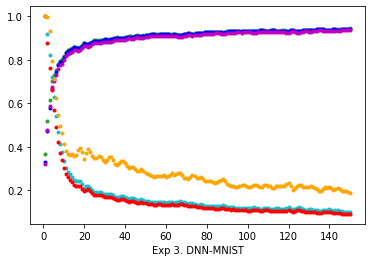

In [16]:
# loss 归一化
max_loss = 0
max_MS_loss = 0
max_train_acc = 0
max_F1 = 0
max_MCC = 0
max_Score = 0

for i in range(len(turns_record)):
    if loss_record[i] > max_loss:
        max_loss = loss_record[i]
    if MS_loss_record[i] > max_MS_loss:
        max_MS_loss = MS_loss_record[i]
    if Score_record[i] > max_Score:
        max_Score = Score_record[i]    

for i in range(len(loss_record)):
    loss_record[i] = loss_record[i]/max_loss
    MS_loss_record[i] = MS_loss_record[i]/max_MS_loss
    Score_record[i] = Score_record[i]/max_Score
    
plt.plot(turns_record, train_acc_record, '.', color = 'tab:green', label='ACC')
plt.plot(turns_record, F1_record, '.', color = 'b', label='F1') # lightpink
plt.plot(turns_record, MCC_record, '.', color = 'm', label='MCC')
plt.plot(turns_record, MS_loss_record, '.', color = 'tab:cyan', label='MS') # turquoise
plt.plot(turns_record, loss_record, '.', color = 'r', label='CE') # blueviolet
plt.plot(turns_record, Score_record, '.', color = 'orange', label='MPWS')

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

LABEL = 'Exp 3'
plt.xlabel(f"{LABEL}. {NAME}")

plt.savefig(f'../Savefig/{LABEL}.png', bbox_inches='tight', dpi=600)  # 保存该图片
plt.show()

In [18]:
import pandas as pd

train_acc_record_df = pd.DataFrame(train_acc_record)
F1_record_df = pd.DataFrame(F1_record)
MCC_record_df = pd.DataFrame(MCC_record)
MS_loss_record_df = pd.DataFrame(MS_loss_record)
loss_record_df = pd.DataFrame(loss_record)
Score_record_df = pd.DataFrame(Score_record)

data_df = pd.concat([train_acc_record_df, F1_record_df, MCC_record_df, MS_loss_record_df, loss_record_df, Score_record_df], axis=1)
data_df.columns = ['Accuracy', 'F1-score', 'MCC', 'Mean Squared', 'Cross Entropy', 'MPWS']  # head

writer = pd.ExcelWriter(f"../Records/{LABEL}. {NAME}.xlsx")
data_df.to_excel(writer,'page_1')
writer.save()

